# What is this notebook for?
This notebook is intended only for visualinsing the left and or right ventricle segmentations for a particular echonet video.

If you want to add other interesting things to the visualisation (such as estimated septum width, etc.), you should use the [other notebook](./weak_labels.ipynb) instead.

In [1]:
from pathlib import Path
import sys
import math
from typing import List, Tuple

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import scipy

import echonet
from weak_labels.utils import get_average_eccentricity, get_min_area_rect, get_min_area_box, mask_to_image, image_to_mask, find_corner, get_angle, BOTTOM_LEFT, BOTTOM_RIGHT, remove_septum

config = dotenv_values(".env")

# Can assign these colours to numpy arrays so long as the colours are stored in
# the last axis of the target array (e.g. image.shape =(112, 112, 3), but not
# image.shape = (3, 112, 112)). 
# Just do image[y_vals, x_vals] = MAGENTA
# IMPORTANT: if using within an *opencv* function, you'll want to do 
# COLOUR.tolist() to convert these to python primitives, else opencv complains about
# datatypes
# Note also that these are BGR, not RGB, since that's what opencv prefers BGR for historical reasons!
RED = np.array([0, 0, 255])
GREEN = np.array([0, 255, 0])
BLUE = np.array([255, 0, 0])
ORANGE = np.array([0, 165, 255])
LIGHT_GREY = np.array([211, 211, 211])
MAGENTA = np.array([255, 0, 255])
YELLOW = np.array([0, 255, 255])
WHITE = np.array([255, 255, 255])
BLACK = np.array([0, 0, 0])

# Just some types for us to use in type hints to make dev easier
Point = List[np.intp]
Box = Tuple[Point, Point, Point, Point]
Rectangle = Tuple[Point, Tuple[float, float], float] # [centre, (width, height), angle]

In [2]:
def get_heights(masks: np.ndarray) -> np.ndarray:
    images = mask_to_image(masks)
    heights = np.zeros(len(images))
    for i, image in enumerate(images):
        ((centre_x, centre_y), (width, height), angle) = get_min_area_rect(image)
        height = max(width, height)
        heights[i] = height

    return heights

def get_angles(masks: np.ndarray) -> np.ndarray:
    images = mask_to_image(masks)
    rects = [get_min_area_rect(image) for image in images]
    angles = np.array([get_angle(rect) for rect in rects])
    return angles


def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    rect = get_min_area_rect(image)
    bottom_left = find_corner(rect, which=BOTTOM_LEFT)
    bottom_left = (int(bottom_left[0]), int(bottom_left[1]))

    rot_mat = cv2.getRotationMatrix2D(bottom_left, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def get_diastoles_systoles(LV_masks):
    LV_areas = LV_masks.sum(axis=(1,2))
    min_area, max_area = LV_areas.min(), LV_areas.max()
    trim_min = sorted(LV_areas)[round(len(LV_areas) ** 0.05)]
    trim_max = sorted(LV_areas)[round(len(LV_areas) ** 0.95)]
    trim_range = trim_max - trim_min
    diastoles = scipy.signal.find_peaks(LV_areas, distance=20, prominence=(0.50 * trim_range))[0]
    systoles = scipy.signal.find_peaks(-LV_areas, distance=20, prominence=(0.50 * trim_range))[0]

    return diastoles, systoles

def crop_box(image: np.ndarray, box: np.array) -> np.ndarray:
    """
    (num_points, x, y)
    [
        [ 64 464]
        [ 64  64]
        [464  64]
        [464 464]
    ]
    """
    min_x = min(p[0] for p in box)
    max_x = max(p[0] for p in box)
    min_y = min(p[1] for p in box)
    max_y = max(p[1] for p in box)
    return image[min_y:max_y, min_x:max_x]

In [4]:
WRITE = False

config = dotenv_values(".env")

echonet_video_fp = (Path
(config["ECHONET_VIDEO_DIR"]) / config["VIDEONAME"]).with_suffix(".avi")
echonet_video = echonet.utils.loadvideo(str(echonet_video_fp))
echonet_video = echonet_video.transpose((1, 2, 3, 0)) # Put colour axis at end for easier colouring of pixels

LV_masks = np.load(config["LV_MASKS"])
RV_masks = np.load(config["RV_MASKS"])

num_frames, frame_height, frame_width = LV_masks.shape
out_height = (frame_height + frame_height // 8) * 4
out_width = frame_width * 4
out_size = (out_width, out_height)
if WRITE:
    print(f"Size: ({frame_width}, {frame_height}) -> ({out_size})")

WINDOW = f"Segmentation: {config['VIDEONAME']}.avi"
WINDOW2 = f"Segmentation (stretched): {config['VIDEONAME']}.avi"
WINDOW3 = f"Segmentation (rotated): {config['VIDEONAME']}.avi"
WINDOW4 = f"Input, but denoised?: {config['VIDEONAME']}.avi"
cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)
cv2.namedWindow(WINDOW2, cv2.WINDOW_NORMAL)
cv2.namedWindow(WINDOW3, cv2.WINDOW_NORMAL)
cv2.namedWindow(WINDOW4, cv2.WINDOW_NORMAL)


thresh = 10
kernel_size = 3
thresh2 = 10
def on_trackbar_thresh(val):
    global thresh
    thresh = val

def on_trackbar_thresh2(val):
    global thresh2
    thresh2 = val

def on_trackbar_kernel_size(val):
    global kernel_size
    kernel_size = val * 2 + 1
    
cv2.createTrackbar("Thresh", WINDOW4, thresh, 255, on_trackbar_thresh)
cv2.createTrackbar("1/2 Kernel size", WINDOW4, kernel_size, 20, on_trackbar_kernel_size)
cv2.createTrackbar("Post-Thresh", WINDOW4, thresh2, 255, on_trackbar_thresh2)

i = 0
is_playing = True

if WRITE:
    writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), 30, out_size)

diastoles, systoles = get_diastoles_systoles(LV_masks)
RV_heights = get_heights(RV_masks)
LV_heights = get_heights(LV_masks)
# RV_LV_height_ratio = RV_heights[diastoles[0]] / LV_heights[diastoles[0]]
RV_LV_height_ratio = (RV_heights / LV_heights).mean()
print(f"RV/LV = {RV_LV_height_ratio:.6f}")
if RV_LV_height_ratio < 0.8:
    RV_stretch_factor = 0.8 / RV_LV_height_ratio
    print(f"Stretching RV heights by {RV_stretch_factor}")
else:
    print("RV height seems reasonable?")
    RV_stretch_factor = 1

RV_angles = get_angles(RV_masks)
RV_angle = np.mean(RV_angles)

try:
    while True:
        if i >= num_frames:
            i = 0
            if WRITE:
                break
        elif i < 0:
            i = num_frames - 1

        # Copy data for this particular frame
        frame = echonet_video[i].copy()
        LV_mask = LV_masks[i].copy()
        RV_mask = RV_masks[i].copy()

        # RV_LV_height_ratio = RV_heights[i] / LV_heights[i]
        # if RV_LV_height_ratio 
        # RV_stretch_factor = 0.8 / RV_LV_height_ratio

        RV_image = mask_to_image(RV_mask)
        # angle = get_angle(get_min_area_rect(RV_image))
        # RV_image = scipy.ndimage.rotate(RV_image, -RV_angle)
        RV_image = cv2.resize(RV_image, (frame_width, frame_height)) # Think this actually *shrinks* the RV segmentation, need to account for this!
        RV_image[RV_image>0] = 255

        # RV_image = rotate_image(RV_image, -angle)
        RV_box = get_min_area_box(RV_image)
        RV_cropped = crop_box(RV_image, RV_box)
        RV_height, RV_width = RV_cropped.shape
        old_shape = RV_cropped.shape
        RV_cropped = cv2.resize(RV_cropped, (RV_width, int(RV_height * RV_stretch_factor)))
        # RV_cropped = rotate_image(RV_cropped, angle=angle)
        # RV_cropped = scipy.ndimage.rotate(RV_cropped, angle=RV_angle, reshape=False)
        # RV_cropped = cv2.resize(RV_cropped, (frame_width, frame_height))

        # print(f"Shapes: {old_shape} -> {RV_cropped.shape}")

        min_x = min(p[0] for p in RV_box)
        max_x = max(p[0] for p in RV_box)
        min_y = min(p[1] for p in RV_box)
        max_y = max(p[1] for p in RV_box)

        # x1, y1 = find_corner(RV_rect, BOTTOM_LEFT)
        # x2, y2 = find_corner(RV_rect, BOTTOM_RIGHT)
        # print(f"Points: ({min_x}, {max_x})  ({min_y}, {max_y})")
        pad_left = min_x
        pad_right = frame_width - max_x
        pad_bottom = frame_height - max_y
        pad_top = max_y - RV_cropped.shape[0]
        # print("Padding: ", pad_left, pad_right, pad_bottom, pad_top)
        RV_padded = np.pad(RV_cropped, ((pad_top, pad_bottom), (pad_left, pad_right)))
        # RV_padded[RV_padded > 0] = 255
        # RV_padded = cv2.medianBlur(RV_padded, 5)
        cv2.imshow(WINDOW3, RV_padded)
        # print("Final shape: ", RV_padded.shape)

        RV_stretched_mask = image_to_mask(RV_padded)

        ######## SEGMENTATIONS
        frame[LV_mask] = RED
        frame[RV_mask] = BLUE

        LV_box = get_min_area_box(mask_to_image(LV_mask))
        RV_box = get_min_area_box(mask_to_image(RV_mask))
        cv2.drawContours(frame, [LV_box], 0, YELLOW.tolist())
        cv2.drawContours(frame, [RV_box], 0, ORANGE.tolist())

        frame2 = echonet_video[i].copy()
        frame2[RV_stretched_mask] = BLUE

        frame3 = echonet_video[i].copy()
        frame3[frame3 < thresh] = 0
        frame3 = cv2.medianBlur(frame3, kernel_size)
        frame3[frame3 < thresh2] = 0
        cv2.imshow(WINDOW4, frame3)

        # images = mask_to_image(RV_masks)
        # contours, _ = cv2.findContours(images[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # (centre_x, centre_y), (minor_radius, major_radius), angle = cv2.fitEllipse(contours[0])
        # cv2.ellipse(frame, [(centre_x, centre_y), (minor_radius, major_radius), angle], GREEN.tolist())
        # ell_ecc = np.sqrt(1 - (minor_radius/major_radius)**2)
        
        frame = cv2.applyColorMap(frame, cv2.COLORMAP_SPRING)

        ####### ADD FRAME COUNTER AT TOP
        top_border = np.zeros((frame_height // 8, frame_width, 3), dtype=frame.dtype)
        top_border[:, :] = np.expand_dims(LIGHT_GREY, (0, 1))
        cv2.putText(top_border, f"Frame {i+1}/{num_frames}", org=(5,10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=RED.tolist())
        frame = np.concatenate([top_border, frame], axis=0)
        # frame2 = np.concatenate([top_border, frame2], axis=0)

        if i in systoles:
            frame[-10:, :] = ORANGE
        elif i in diastoles:
            frame[-10:, :] = GREEN

        ######## SHOW SEGMENTATION AND HANDLE KEYPRESS
        


        cv2.imshow(WINDOW, frame)
        cv2.imshow(WINDOW2, frame2)

        if WRITE:
            frame = cv2.resize(frame, out_size)
            writer.write(frame)

        keypress = cv2.waitKey(25) & 0xFF
        if keypress == ord('q'):
            break
        elif keypress == ord(' '):
            is_playing = not is_playing
        elif keypress == ord('a'):
            i -= 1
        elif keypress == ord('d'):
            i += 1
        else:
            if is_playing:
                i += 1
finally:
    cv2.destroyAllWindows() 
    if WRITE:
        writer.release()

RV/LV = 0.634304
Stretching RV heights by 1.261225386945107


In [29]:
RV_LV_height_ratio

0.6815932540464239

In [6]:
from weak_labels.utils import mask_to_image, get_average_eccentricity
images = mask_to_image(RV_masks)
contours, _ = cv2.findContours(images[0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
(centre_x, centre_y), (minor_radius, major_radius), angle = cv2.fitEllipse(contours[0])
ell_ecc = np.sqrt(1 - (minor_radius/major_radius)**2)

print("From rectangle", get_average_eccentricity(RV_masks))
print("From ellipse", ell_ecc)

From rectangle 0.8990815108628878
From ellipse 0.9170112007036298


In [7]:
# This cell is just for playing around with rotated rectangles and their corners,
# while we figure out how on earth opencv determines the angle in its return value
# for cv2.minAreaRect()!
WINDOW = "Mask"
cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)

frame_width = frame_height = 528
frame = np.zeros((frame_height, frame_width), dtype=np.uint8)
width = 400
height = 400
angle = 0.002
centre_x = frame_height // 2
centre_y = frame_width // 2
corner1 = (centre_x - width // 2, centre_y - height // 2)
corner2 = (centre_x + width // 2, centre_y + height // 2)
frame = cv2.rectangle(frame, corner1, corner2, 255, -1)

matrix = cv2.getRotationMatrix2D((centre_x, centre_y), angle, 1)
frame = cv2.warpAffine(frame, matrix, (frame_height, frame_width))

box = get_min_area_box(frame)
rect = get_min_area_rect(frame)
our_angle = get_angle(rect)
# print(our_angle)
print(rect)
# print(box)
frame = np.zeros((frame_height, frame_width), dtype=np.uint8)
cv2.drawContours(frame,[box],0, 255)

# bottom_left = find_corner(rect, BOTTOM_LEFT)
# frame[bottom_left[1], bottom_left[0]] = 255

frame = np.flip(frame, axis=-1)

while True:
    cv2.imshow(WINDOW, frame)

    keypress = cv2.waitKey(50) & 0xFF
    if keypress == ord('q'):
        break

cv2.destroyAllWindows()

((264.0, 264.0), (400.0, 400.0), 0)


In [6]:
eccs = np.array([0.7545, 0.9139, 0.8341, 0.8378, 0.8331, 0.5455, 0.7886, 0.6353,
       0.9032, 0.9559, 0.8291, 0.8673, 0.7835, 0.688 , 0.7497, 0.793 ,
       0.8063, 0.7447, 0.8413, 0.801 , 0.9251, 0.8095, 0.8866, 0.8578,
       0.7454, 0.7633, 0.6504, 0.8612, 0.8829, 0.8556, 0.7998, 0.8248,
       0.8622, 0.8411, 0.8665, 0.7666, 0.8264, 0.7971, 0.6028, 0.8427,
       0.7814, 0.7559, 0.821 , 0.5744, 0.8071, 0.7773, 0.7016, 0.6162,
       0.8074, 0.8991, 0.7544, 0.7971, 0.7734, 0.8903, 0.6663, 0.8793,
       0.9013, 0.8378, 0.8867, 0.8345, 0.8534, 0.7872, 0.8423, 0.8435,
       0.8931, 0.8737, 0.8805, 0.8576, 0.8757, 0.7749, 0.8636, 0.8426,
       0.8741, 0.7946, 0.8762, 0.8271, 0.6841, 0.6228, 0.8054, 0.7878,
       0.7489, 0.8234, 0.8507, 0.833 , 0.5016, 0.755 , 0.9082, 0.8568,
       0.8885, 0.8863, 0.8472, 0.7979, 0.8787, 0.6902, 0.6156, 0.8538,
       0.8311, 0.8823, 0.8676, 0.8545, 0.9145, 0.8356, 0.7202, 0.8442,
       0.8416, 0.8296, 0.8805, 0.8971, 0.825 , 0.7488, 0.7789, 0.7402,
       0.7594, 0.7833, 0.84  , 0.8433, 0.8841, 0.8745, 0.7741, 0.8017,
       0.8085, 0.7021, 0.6631, 0.8533, 0.771 , 0.8317, 0.9106, 0.826 ,
       0.789 , 0.8678, 0.6788, 0.7271, 0.8846, 0.9454, 0.8695, 0.8089,
       0.8405, 0.8918, 0.5358, 0.7859, 0.8755, 0.839 , 0.6913, 0.8724,
       0.761 , 0.815 , 0.8296, 0.8106, 0.8595, 0.8415, 0.873 , 0.8182,
       0.815 , 0.6101, 0.7566, 0.7578, 0.8072, 0.8264, 0.881 , 0.9033,
       0.8303, 0.8731, 0.8927, 0.8603, 0.9068, 0.7087, 0.7516, 0.851 ,
       0.7782, 0.8522, 0.8294, 0.8543, 0.8645, 0.8697, 0.5316, 0.84  ,
       0.8036, 0.8531, 0.8315, 0.8264, 0.8807, 0.4856, 0.7929, 0.8091,
       0.8463, 0.7948, 0.575 , 0.9176, 0.7317, 0.8342, 0.5061, 0.8192,
       0.8555, 0.6084, 0.8659, 0.8196, 0.8665, 0.7915, 0.9276, 0.7411,
       0.9124, 0.8648, 0.8865, 0.8874, 0.8096, 0.8827, 0.8848, 0.4997,
       0.844 , 0.8938, 0.8017, 0.8648, 0.8309, 0.8882, 0.6597, 0.7776,
       0.8414, 0.7562, 0.7886, 0.7773])

(array([ 5.,  4.,  6.,  5.,  9., 21., 42., 66., 53.,  9.]),
 array([0.4856 , 0.53263, 0.57966, 0.62669, 0.67372, 0.72075, 0.76778,
        0.81481, 0.86184, 0.90887, 0.9559 ]),
 <BarContainer object of 10 artists>)

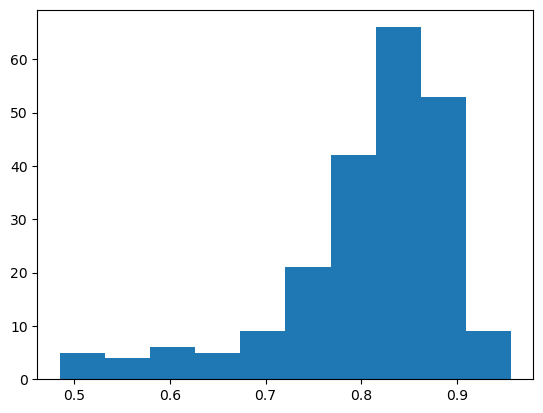

In [7]:
plt.hist(eccs)

In [8]:
((eccs < 0.65) | (eccs > 0.96)).sum()

16

(array([4., 2., 1., 3., 3., 5., 9., 5., 3., 9.]),
 array([0.8091 , 0.81235, 0.8156 , 0.81885, 0.8221 , 0.82535, 0.8286 ,
        0.83185, 0.8351 , 0.83835, 0.8416 ]),
 <BarContainer object of 10 artists>)

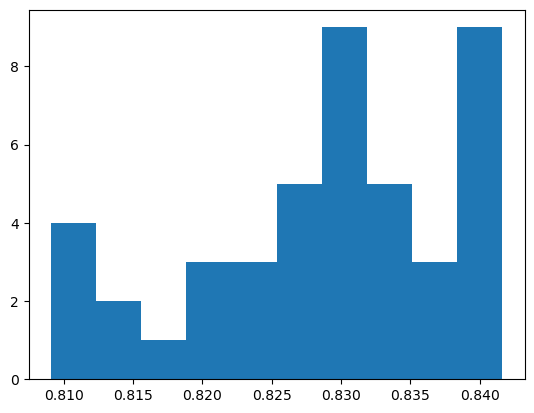

In [10]:
sorted(eccs)[int(len(eccs) * 0.4):int(len(eccs) * 0.6)]

In [48]:
frame_i, yi, xi = np.where(LV_masks)

In [ ]:
yi.mean()